In [156]:
#pip install tensorflow==2.9.2

In [2]:
import pandas as pd
import numpy as np
import re
import jieba
import matplotlib.pyplot as plt

In [155]:
df = pd.read_excel('../data/sentiment_analysis_latest.xlsx')

In [4]:
df['sentiment_label'].value_counts()

neutral     3267
negative    1943
positive     959
Name: sentiment_label, dtype: int64

In [154]:
replace_tag = {'positive':2, 'neutral':1, 'negative':0}
df['sentiment_label']= df['sentiment_label'].replace(replace_tag)

# 1. tokenization

In [6]:
# load self-defined tokenization dictionary
jieba.set_dictionary('../data/tokenization_dict/dict.txt')
jieba.load_userdict('../data/tokenization_dict/hk_dict.txt')

Building prefix dict from C:\Users\Harrison\Downloads\2023_07_19_supplemet_material\2023_07_19_supplemet_material\data\tokenization_dict\dict.txt ...
Loading model from cache C:\Users\Harrison\AppData\Local\Temp\jieba.u92fdb9fc4f964cbd4d35e3368f83bac9.cache
Loading model cost 0.660 seconds.
Prefix dict has been built successfully.


In [7]:
# import stopwords list
import pycantonese
stop_words = pycantonese.stop_words()
stop_words  

{'一啲',
 '一定',
 '不如',
 '不過',
 '之後',
 '乜',
 '乜嘢',
 '人哋',
 '但係',
 '你',
 '你哋',
 '佢',
 '佢哋',
 '係',
 '個',
 '其他',
 '冇',
 '再',
 '到',
 '即',
 '即係',
 '原來',
 '去',
 '又',
 '可以',
 '可能',
 '同',
 '同埋',
 '吖',
 '呀',
 '呢',
 '咁',
 '咗',
 '咩',
 '咪',
 '哦',
 '哩',
 '哩個',
 '哩啲',
 '哩度',
 '哩樣',
 '唔',
 '唔使',
 '唔係',
 '啊',
 '啲',
 '喎',
 '喺',
 '喺度',
 '嗯',
 '嗰',
 '嗰個',
 '嗰啲',
 '嗰度',
 '嘅',
 '嘢',
 '噉',
 '噉樣',
 '因為',
 '多',
 '太',
 '好',
 '如果',
 '就',
 '已經',
 '幾',
 '幾多',
 '得',
 '想',
 '應該',
 '成日',
 '我',
 '我哋',
 '或者',
 '所以',
 '最',
 '會',
 '有',
 '有冇',
 '有啲',
 '未',
 '梗係',
 '然之後',
 '由',
 '真係',
 '睇',
 '知',
 '而',
 '而家',
 '自己',
 '要',
 '覺得',
 '話',
 '諗',
 '講',
 '譬如',
 '跟住',
 '返',
 '過',
 '邊個',
 '都',
 '點',
 '點樣',
 '點解'}

In [152]:
# keep Chinese char, English words and numbers, and then remove stopwords
stop_words = [w.replace('\n', '') for w in stop_words]
stop_words = [w.replace(' ', '') for w in stop_words]
speech_list = list(df['msg_replace'])
rule = re.compile(r"[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a\u4e00-\u9fa5]")
speech_list = [list(jieba.cut(rule.sub('', speech))) for speech in speech_list]
for idx, speech in enumerate(speech_list):
    speech_list[idx] = ' '.join([word for word in speech if word.strip() not in stop_words])

In [153]:
df['msg_token'] = speech_list

# 2. training and test set split

In [35]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout
from keras.optimizers import Adam

In [65]:
MAX_NB_WORDS = 3000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 100

df['msg_token'] = df['msg_token'].fillna("")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['msg_token'].values)
word_index = tokenizer.word_index
print('There are totally %s different tokens.' % len(word_index))

There are totally 10442 different tokens.


In [72]:
# vectorization
X = tokenizer.texts_to_sequences(df['msg_token'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
Y = pd.get_dummies(df['sentiment_label']).values

print(X.shape)
print(Y.shape)

(6169, 300)
(6169, 3)


In [73]:
# split training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4935, 300) (4935, 3)
(1234, 300) (1234, 3)


In [74]:
X

array([[   0,    0,    0, ...,   64,    6,   65],
       [   0,    0,    0, ...,   65,   26,   17],
       [   0,    0,    0, ...,  167, 1257,  912],
       ...,
       [   0,    0,    0, ...,    0,    0,   17],
       [   0,    0,    0, ...,    0, 1143,  526],
       [   0,    0,    0, ...,  206,   25,  526]])

# 3. LSTM model

In [151]:
# model hyperparameter setting
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(256,  activation='relu'))
model.add(Dense(3, activation='softmax'))
optimizer=Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 300, 100)          300000    
                                                                 
 lstm_26 (LSTM)              (None, 100)               80400     
                                                                 
 dense_40 (Dense)            (None, 256)               25856     
                                                                 
 dense_41 (Dense)            (None, 3)                 771       
                                                                 
Total params: 407,027
Trainable params: 407,027
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Harrison\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [143]:
# model training 
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/10
70/70 [==============================] - 22s 287ms/step - loss: 0.8880 - accuracy: 0.5981 - val_loss: 0.8585 - val_accuracy: 0.6012
Epoch 2/10
70/70 [==============================] - 15s 215ms/step - loss: 0.6919 - accuracy: 0.7179 - val_loss: 0.8638 - val_accuracy: 0.6417
Epoch 3/10
70/70 [==============================] - 14s 205ms/step - loss: 0.6043 - accuracy: 0.7494 - val_loss: 1.0606 - val_accuracy: 0.6012
Epoch 4/10
70/70 [==============================] - 14s 206ms/step - loss: 0.5784 - accuracy: 0.7669 - val_loss: 1.0784 - val_accuracy: 0.5891
Epoch 5/10
70/70 [==============================] - 15s 211ms/step - loss: 0.5773 - accuracy: 0.7665 - val_loss: 1.0876 - val_accuracy: 0.5729
Epoch 6/10
70/70 [==============================] - 15s 208ms/step - loss: 0.5779 - accuracy: 0.7683 - val_loss: 1.1226 - val_accuracy: 0.5951
Epoch 7/10
70/70 [==============================] - 14s 205ms/step - loss: 0.5670 - accuracy: 0.7755 - val_loss: 1.1765 - val_accuracy: 0.5769

# 4. evaluation

In [144]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

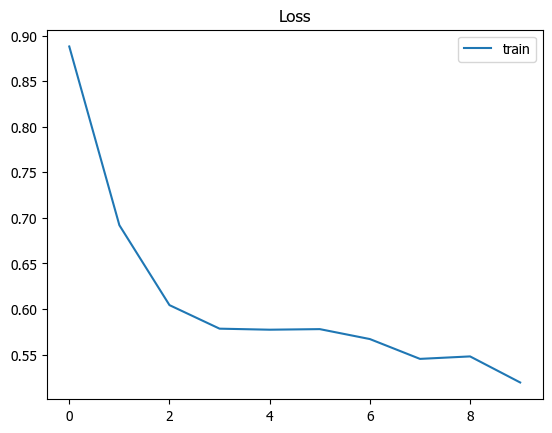

In [145]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show();

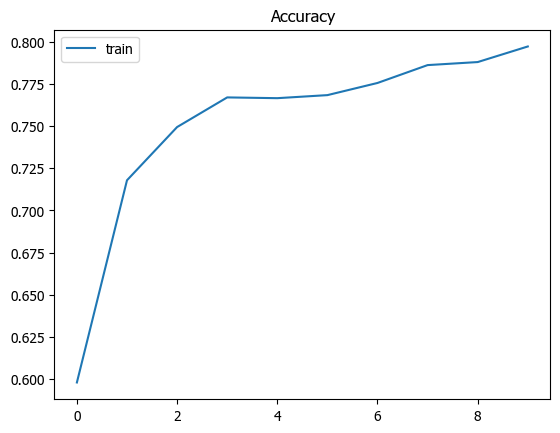

In [146]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.show();

In [147]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis = 1)

39/39 [==============================] - 1s 20ms/step


In [148]:
Y_test

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [149]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [150]:
from sklearn.metrics import classification_report
target_names = ['0', '1', '2']
print(classification_report(Y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       380
           1       0.70      0.73      0.72       666
           2       0.41      0.38      0.40       188

    accuracy                           0.64      1234
   macro avg       0.58      0.57      0.57      1234
weighted avg       0.63      0.64      0.63      1234

